In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut, cross_val_score, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from IPython import display
from IPython.display import Image
from load_dataset import load_data
import utils

## Instancier le jeu de données

In [70]:
X, y, cat_features = load_data().get_data_X_y(data='simplify')

# Arbre de décision

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy : ", accuracy_score(y_test, y_pred) * 100, "\n")
print(classification_report(y_test, y_pred))


Accuracy :  85.2157943067034 

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       414
           1       0.88      0.88      0.88       675

    accuracy                           0.85      1089
   macro avg       0.84      0.84      0.84      1089
weighted avg       0.85      0.85      0.85      1089



# Optimisation du modèle

In [72]:
# Les hyperparamètres à tester
param_grid = {
    'max_depth': [6, 8, 10, 12, 15], 
    'min_samples_split': [50, 100, 190, 200, 210, 225, 250],
    'min_samples_leaf': [15, 20, 25, 30, 40, 60, 100, 150], 
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_


resultats = {
    'max_depth': [],
    'min_samples_split': [],
    'min_samples_leaf': [],
    'criterion': []
}
resultats['max_depth'].append(best_params.get('max_depth'))
resultats['min_samples_split'].append(best_params.get('min_samples_split'))
resultats['min_samples_leaf'].append(best_params.get('min_samples_leaf'))
resultats['criterion'].append(best_params.get('criterion'))



df = pd.DataFrame(resultats)
print('les hyperparametres optimaux:')
display.display(df)


# Évaluation
best_model = grid_search.best_estimator_

best_cv_score = grid_search.best_score_
print(f'Moyenne des scores (f1) de validation croisé: {best_cv_score * 100:.3f}%\n')


y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy sur l'ensemble de test apres optimisation: {accuracy * 100:.3f}%\n")

print(classification_report(y_test, y_pred))

les hyperparametres optimaux:


,max_depth,min_samples_split,min_samples_leaf,criterion
0,6,50,15,gini


Moyenne des scores (f1) de validation croisé: 90.794%

Accuracy sur l'ensemble de test apres optimisation: 89.532%

              precision    recall  f1-score   support

           0       0.91      0.81      0.85       414
           1       0.89      0.95      0.92       675

    accuracy                           0.90      1089
   macro avg       0.90      0.88      0.89      1089
weighted avg       0.90      0.90      0.89      1089



## Extraires les features qui sont importants

In [73]:
utils.features_importance(best_model, X_train.columns, plot=False)

,Importance
Unités curriculaires 2e semestre (approuvées),0.795291
Frais de scolarité à jour,0.100373
Unités curriculaires 2e semestre (inscrits),0.051270
Unités curriculaires 2e semestre (évaluations),0.009433
Unités curriculaires 1er semestre (créditées),0.009083
Unités curriculaires 1er semestre (évaluations),0.008149
Unités curriculaires 1er semestre (approuvées),0.005293
Qualification père,0.004568
Unités curriculaires 1er semestre (note),0.003736
Taux d'inflation,0.003604


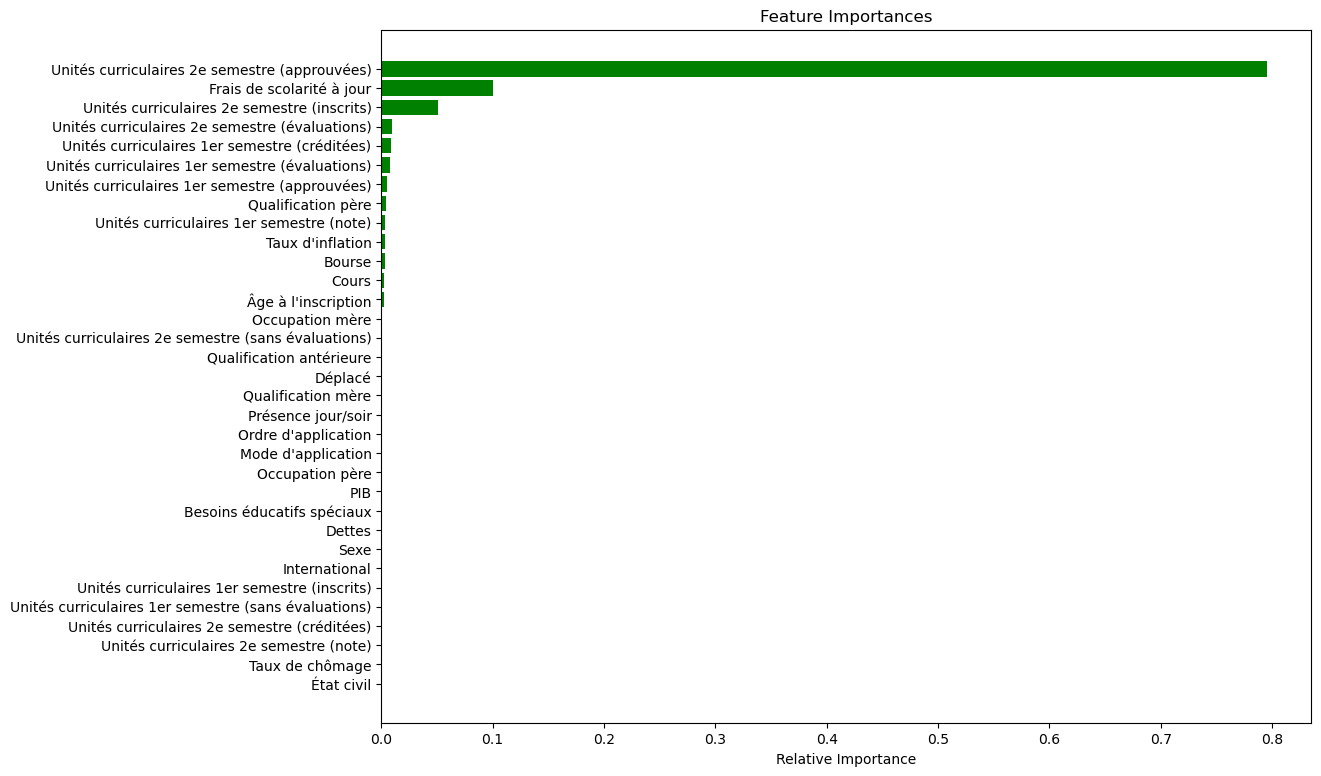

In [74]:
utils.features_importance(best_model, X_train.columns, plot=True)

# Voir l'arbre

In [75]:
# # un modele DT avec les meilleurs hp
# clf = DecisionTreeClassifier(
#     criterion='gini',
#     max_depth=6,
#     min_samples_split=210,
#     min_samples_leaf=15,
#     random_state=42
# )

# clf.fit(X_train, y_train)

# class_names = [str(x) for x in clf.classes_]
# dot_data = export_graphviz(
#     clf, 
#     out_file=None, 
#     feature_names=X_train.columns, 
#     class_names=class_names, 
#     filled=True,
#     rounded=True,
#     special_characters=True
# )

# graph = graphviz.Source(dot_data)
# graph.render("./Arbre de decision") 

# Image(graph.pipe(format='png'))


## Test : sélection de juste quelques features, avec la méthode SelectFromModel

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

selector = SelectFromModel(clf, prefit=True, threshold='mean')
X_train_reduced = selector.transform(X_train)  
X_test_reduced = selector.transform(X_test)  


param_grid = {
    'max_depth': [6, 8, 10, 12, 15], 
    'min_samples_split': [50, 100, 190, 200, 210, 225, 250],
    'min_samples_leaf': [15, 20, 25, 30, 40, 60, 100, 150], 
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train_reduced, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_cv_score = grid_search.best_score_
print(f'Moyenne des scores (f1) de validation croisé: {best_cv_score * 100:.2f}%\n')

y_pred_test = best_model.predict(X_test_reduced)
print("Accuracy sur l'ensemble de test: ", accuracy_score(y_test, y_pred_test) * 100)


/Users/jacobcomeau/miniconda3/envs/Jake_env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/jacobcomeau/miniconda3/envs/Jake_env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Moyenne des scores (f1) de validation croisé: 90.90%

Accuracy sur l'ensemble de test:  89.53168044077135


In [77]:
feature_idx = selector.get_support()
feature_name = X.columns[feature_idx]

utils.features_importance(best_model, feature_name)

,Importance
Unités curriculaires 2e semestre (approuvées),0.761494
Frais de scolarité à jour,0.111517
Unités curriculaires 2e semestre (inscrits),0.096384
Cours,0.030604


## Test: sélection de juste quelques features, avec la méthode SelectKBest

In [78]:
best_k = None
best_accuracy = 0
for k in range(1, X_train.shape[1] + 1):

    selector = SelectKBest(f_classif, k=k).fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    model = DecisionTreeClassifier(random_state=42).fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f"Meilleur nbre de features : {best_k} avec une accuracy de {best_accuracy:.2%}%")

selected_indices = selector.get_support(indices=True)

selected_features_names = X.columns[selected_indices]
#print("features selectionnés :")
#for feature in selected_features_names:
#    print(feature)


selector = SelectKBest(f_classif, k=best_k).fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


param_grid = {
    'max_depth': [6, 8, 10, 12, 15], 
    'min_samples_split': [50, 100, 190, 200, 210, 225, 250],
    'min_samples_leaf': [15, 20, 25, 30, 40, 60, 100, 150], 
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_model = grid_search.best_estimator_

best_cv_score = grid_search.best_score_
print(f'Moyenne des score (f1) de validation croisé: {best_cv_score * 100:.2f}%\n')


y_pred = best_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy sur l'ensemble de test: {accuracy * 100:.3}%")

Meilleur nbre de features : 19 avec une accuracy de 88.25%%
Moyenne des score (f1) de validation croisé: 90.74%

Accuracy sur l'ensemble de test: 90.3%


## Test: utiliser One-Hot-Encoding pour transformer les variables nominales categorielles en colonne binaires 0 ou 1

In [79]:
X, y, cat_features = load_data().get_data_X_y(data='simplify', OneHot=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'max_depth': [6, 8, 10, 12, 15], 
    'min_samples_split': [50, 100, 190, 200, 210, 225, 250],
    'min_samples_leaf': [15, 20, 25, 30, 40, 60, 100, 150], 
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_cv_score = grid_search.best_score_
print(f'Moyenne des scores (f1) de validation croisé: {best_cv_score * 100:.2f}%\n')

y_pred = best_model.predict(X_test)
print("Accuracy sur l'ensemble de test: ", accuracy_score(y_test, y_pred) * 100)

Moyenne des scores (f1) de validation croisé: 90.95%

Accuracy sur l'ensemble de test:  89.8989898989899
